In [5]:
import numpy as np
from astropy import units as u
from astropy.io import fits
from matplotlib import pyplot as plt
import scipy
import scipy.interpolate
from scipy import ndimage

In [2]:
clay = fits.open('ClayM1_0mask_meters_new.fits')[0]
surf = clay.data
hdr = clay.header
hdr

SIMPLE  =                    T /Primary Header created by MWRFITS v1.8          
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  233 /                                                
NAXIS2  =                  233 /                                                
EXTEND  =                    T /Extensions may be present                       
PUPLSCAL=  0.02789699570815451 / pixel scale [m/pix]                            
BUNIT   = 'm       '           / OPD Units                                      

In [3]:
# build the coordinate points for the original data
data_pixscl = hdr['puplscal']*u.m
side = surf.shape[0]*data_pixscl
side_half = side/2
oy, ox = np.mgrid[-side_half.value:side_half.value:233j,
                  -side_half.value:side_half.value:233j]
orig_y = np.reshape(np.flipud(oy), np.product(oy.shape))
orig_x = np.reshape(ox, np.product(ox.shape))
    
# build the grids for the poppy scale
pixscl = 0.01208178439*u.m # pre-calculated from poppy
zoom_scl = (data_pixscl.value/pixscl.value)
new_npix = np.ceil(zoom_scl*surf.shape[0]).astype(int)
npix_half = int(new_npix/2)
ny, nx = np.mgrid[-npix_half:npix_half,
                  -npix_half:npix_half]
new_y = np.flipud(ny)*pixscl
new_x = nx*pixscl

npix_half*2

538

Text(0.5, 1.0, 'Magellan Clay M1 (surface, interp)')

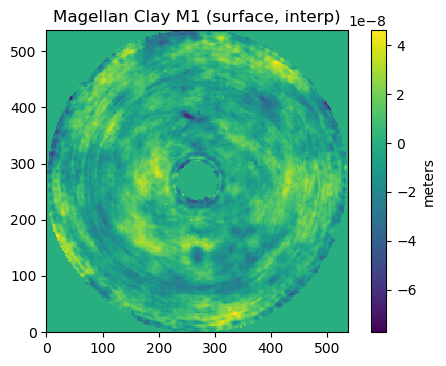

In [7]:
# interpolate the data
lin_surf = np.reshape(surf, np.product(surf.shape))
interp_surf = scipy.interpolate.griddata((orig_y,orig_x), lin_surf, (new_y, new_x),
                                         method='nearest', fill_value=0.0)
plt.figure(dpi=100)
plt.imshow(interp_surf, origin='lower')
plt.colorbar().set_label('meters')
plt.title('Magellan Clay M1 (surface, interp)')

In [8]:
# set as OPD
opd = interp_surf * 2 * u.m

# write to file
fits_hdr = fits.Header()
fits_hdr['puplscal'] = (pixscl.value, 'pixel scale [m/pix]')
fits_hdr['bunit'] = (str(opd.unit), 'OPD units')
fits.writeto('ClayM1_0mask_meters_opd_538.fits', 
             opd.value, fits_hdr, overwrite=True)